### Edgar Moises Hernandez-Gonzalez
#### 26/02/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = RWE-DWT
##### 2 canales C3 y C4
##### 5 ejecuciones independientes

##### Sujeto 1
##### Accuracy = 32.99%
##### Kappa = 0.1065

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [0]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE_DWT/MI-EEG-RWE-A01T.csv", header=None).iloc[:, 21:24]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE_DWT/MI-EEG-RWE-A01T.csv", header=None).iloc[:, 33:36]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE_DWT/MI-EEG-RWE-A01E.csv", header=None).iloc[:, 21:24]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE_DWT/MI-EEG-RWE-A01E.csv", header=None).iloc[:, 33:36]

In [0]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE_DWT/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE_DWT/EtiquetasA01E.csv", header=None)

In [0]:
x_train = np.concatenate((c3_train, c4_train), axis=1)
x_test = np.concatenate((c3_test, c4_test), axis=1)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 6)
(288, 6)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#escalar los datos para que tengan media = 0 y desviacion estandar = 1
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#convertir de 2D a 4D
x_train = x_train.reshape((n_samples_train, 2, 3, 1))
x_test = x_test.reshape((n_samples_test, 2, 3, 1))

print(x_train.shape)
print(x_test.shape)

(288, 2, 3, 1)
(288, 2, 3, 1)


In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  return model

Iteration: 1
288/288 - 0s - loss: 1.4776 - acc: 0.3194
kappa:  0.09259259259259256
f1: 0.30394864493088636
confusion matrix:
 [[33 27  5  7]
 [29 28  7  8]
 [22 20  8 22]
 [23 20  6 23]]


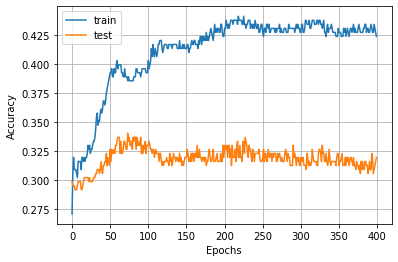

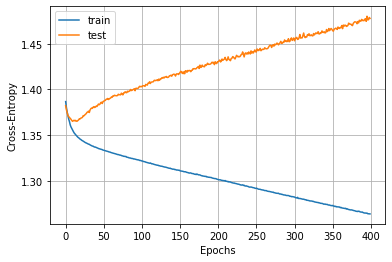

Iteration: 2
288/288 - 0s - loss: 1.4963 - acc: 0.3299
kappa:  0.10648148148148151
f1: 0.3166873243143643
confusion matrix:
 [[36 23  6  7]
 [30 26  9  7]
 [18 21 10 23]
 [23 16 10 23]]


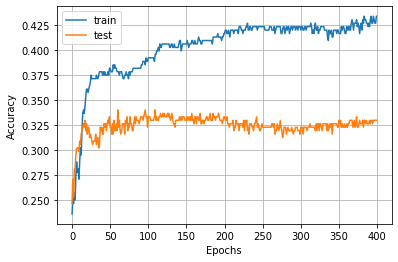

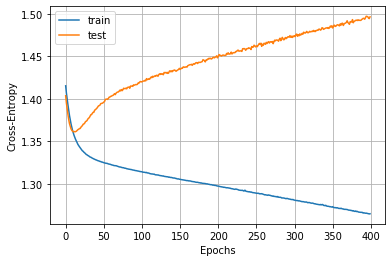


Resultados:
loss: [1.4776034222708807, 1.49627419312795]
accuracy: [0.31944445, 0.3298611]
kappa: [0.09259259259259256, 0.10648148148148151]
f1: [0.30394864493088636, 0.3166873243143643]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
array_f1 = []
for i in range(2):
    print("Iteration:", i+1);
    
    model = CNN_2D()

    history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                        validation_data=(x_test, y_test), verbose=0)
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    array_loss.append(test_loss)
    array_acc.append(test_acc)
    
    probabilidades = model.predict(x_test)
    y_pred = np.argmax(probabilidades, 1) #1=fila
    
    kappa = cohen_kappa_score(y_test, y_pred)
    array_kappa.append(kappa)
    print("kappa: ", kappa)

    f1 = f1_score(y_test, y_pred, average='macro')
    array_f1.append(f1)
    print("f1:", f1)
    
    matriz_confusion = confusion_matrix(y_test, y_pred)
    print("confusion matrix:\n", matriz_confusion)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy')
    plt.legend(['train', 'test'])
    plt.show()
    
print()    
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
print("f1:", array_f1)

In [0]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 2, 3, 32)          320       
_________________________________________________________________
flatten_30 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 32)                6176      
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 132       
Total params: 6,628
Trainable params: 6,628
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("Mean F1: %.4f" % np.mean(array_f1))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Max F1: %.4f" % np.max(array_f1))

Mean Accuracy: 0.3247
Mean Kappa: 0.0995
Mean F1: 0.3103
Max Accuracy: 0.3299
Max Kappa: 0.1065
Max F1: 0.3167
